# Data Cleaning project
A pre-EDA step.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pathlib
pathlib.Path().absolute()

WindowsPath('C:/Users/rafal.klat/Jupyters/DataCleaning')

In [86]:
df = pd.read_csv('dataset.csv')
# OGARNĄĆ I OPISAĆ ŹRÓDŁO
# https://www.quora.com/Where-can-I-get-messy-data-to-work-on-data-cleaning-skills

In [139]:
# df.drop(labels=['Unique Project ID'], axis=1, inplace=True)
# df.to_csv('dataset.csv')
# df.drop(labels=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)
# df.rename(columns={'Agency Code':'Agency ID'}, inplace=True)
df['Agency Project ID'].unique()

array([nan, 'P0049-101', 'P0049-102', ..., '3830', '3831', '3832'],
      dtype=object)

In [105]:
# df.rename(columns={'Unique Investment Identifier':'Investment ID'}, inplace=True)
df['Business Case ID'] = df['Business Case ID'].astype(int)
# indices_to_drop = df.loc[df['Business Case ID'].isna()].index
# df.drop(indices_to_drop, inplace=True)
# df['Business Case ID'].sort_values()
df.dtypes

Investment ID                                     object
Business Case ID                                   int32
Agency Code                                      float64
Agency Name                                       object
Investment Title                                  object
Project ID                                       float64
Agency Project ID                                 object
Project Name                                      object
Project Description                               object
Start Date                                        object
Completion Date (B1)                              object
Planned Project Completion Date (B2)              object
Projected/Actual Project Completion Date (B2)     object
Planned Cost ($ M)                               float64
Projected/Actual Cost ($ M)                      float64
Updated Date                                      object
Updated Time                                      object
dtype: object

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 20 columns):
Unnamed: 0                                       2494 non-null int64
Unnamed: 0.1                                     2494 non-null int64
Unique Investment Identifier                     2494 non-null object
Business Case ID                                 2468 non-null float64
Agency Code                                      2468 non-null float64
Agency Name                                      2468 non-null object
Investment Title                                 2468 non-null object
Project ID                                       2468 non-null float64
Agency Project ID                                1313 non-null object
Project Name                                     2468 non-null object
Project Description                              2468 non-null object
Start Date                                       2451 non-null object
Completion Date (B1)                             245

In [78]:
# There are rows with Totals. It doesn't add any value, but only complicates the analysis.
indices_to_drop = df.loc[df['Business Case ID'].isna()].index
df.drop(indices_to_drop, inplace=True)

2469

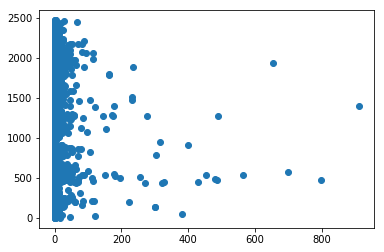

In [66]:
x = df[df['Projected/Actual Cost ($ M)']<1000]['Projected/Actual Cost ($ M)']
y = range(len(x))

# plt.hist(x, bins=100)
# plt.yscale('log')
plt.scatter(x,y)
len(x)

In [ ]:
# todo:

# Unique Investment Identifier - czy tam zawsze jest 005?
#Business Case ID, Agency Code, Project ID - wyglada, ze to moga byc inty
# Agency Name - moze to sa tylko departamenty?
# dates i times -> timestamps
# Cost Variance - dobre jednostki? 
# unique porojet id moze jako pierwsze/drugie?
# NaN -> None/null
# project name - powtarzaja sie, ale prawie (np. 3 i 4)
# inny index (któreś ID)
# project ID vs unique project ID
# czy w Agency Project ID cos w ogole jkest?
# ID vs Identifier
# 1 kolumna z unique ID nie jest unique


#sprawdzic unique values
# info() - tylko objects i float64
# describe()
# min i max


## Cleaning columns one by one
1. `Unique Investment Identifier`:
    1. Not unique, despite the name. It shouldn't be the first column, because it looks like Primary Key.
	2. **Identifier** could be **ID**.

In [ ]:
# Rename the column
df.rename(columns={'Unique Investment Identifier':'Investment ID'}, inplace=True)

2. `Business Case ID`
    1. It is float, but should be int.
    2. It corresponds 1:1 with `Investment ID`, so it should be kept in another lookup table.
    3. There are some `NInvestment IDaN` values. These are rows with totals and they should be removed - they don't add any value, but only complicate an analysis.

In [144]:
# Drop rows with totals
indices_to_drop = df.loc[df['Business Case ID'].isna()].index
df.drop(indices_to_drop, inplace=True)

# Change type to int
df['Business Case ID'] = df['Business Case ID'].astype(int)

# Save into another DF
business_case = pd.DataFrame(data=df[['Investment ID', 'Business Case ID']])
business_case.drop_duplicates(inplace=True)
business_case.set_index(keys='Investment ID', inplace=True)

# Export into a file
business_case.to_csv('business_case.csv')

# Drop extracted columns
df.drop(labels=['Investment ID', 'Business Case ID'], axis=1, inplace=True)

3. `Agency Code`
    1. **Code** could be **ID**.
	2. It is float, but should be int.

In [118]:
# Rename the column to `Agency ID`:
df.rename(columns={'Agency Code':'Agency ID'}, inplace=True)

# Change type to int
df['Agency ID'] = df['Agency ID'].astype(int)

4. `Agency Name`
	1. It corresponds 1:1 with `Agency Code`, so it should be kept in another lookup table. In fact there are only two cases in whole DataFrame, where `Agency ID` doesn't reflect `Agency Name` ideally. By comparing lengths of `Agency ID`, `Agency Name` and pair of these two, we see that there is **one more of unique entries** within Code+Name pair. By checking uniqueness we can conclude that value `6` is our point of pain. Two entries, which have wrong `Agency ID` values (not `Agency Name`, what can be easily deduced from other entries), should have `5`. 

In [133]:
# Define indices of rows to be changed
indices_to_change = df[(df['Agency ID'] == 6) & (df['Agency Name'] != 'Department of Commerce')].index

# Assign new values
for index in indices_to_change:
    df.at[index, 'Agency ID'] = 5

5. `Investment Title`
    1. There are some minor formatting problems (e.g. '&amp;' instead of '&'), however they won't be touched, because these are long business names and could be defined and described somewhere else with whichever formatting.

6. `Project ID`
    1. It's a float, but should be an int.
	2. It's unique, so it should be the Primary Key and the first column in data set. This fits also the business context of the whole data set. 

In [135]:
# Change type to int
df['Project ID'] = df['Project ID'].astype(int)

# Set index
df.set_index(keys='Project ID', inplace=True)

7. `Agency Project ID`
	1. Almost half of the values are NaN (but read by Pandas correctly). Since these are some IDs of internal use of agencies, they won't be touched.

8. `Project Name`
	1. It corresponds with `Project ID`, so it should be kept in another lookup table with `Project Description` (see next point) in a `project_descriptions` table.

9. `Project Description`
	1. It corresponds with `Project ID`, so it should be kept in another lookup table with `Project Name` in a `project_descriptions` table.

In [145]:
# Save into another DF
project_descriptions = pd.DataFrame(data=df[['Project Name', 'Project Description']])
project_descriptions.drop_duplicates(inplace=True)

# Export into a file
project_descriptions.to_csv('project_descriptions.csv')

# Drop extracted columns
df.drop(labels=['Project Name', 'Project Description'], axis=1, inplace=True)

10. `Start Date`
	1. It's an object (Pandas' string), but should be a date.

In [151]:
df['Start Date'] = pd.to_datetime(arg=df['Start Date'])

11. `Completion Date (B1)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)

In [174]:
import re

# Define a parser for two different formats
def date_parser(arg):
    p = re.compile('[0-9]{4}-[0-9]{2}-[0-9]{2}')
    if p.match(str(arg)):
        return pd.to_datetime(arg=arg, format='%Y-%d-%m')
    return pd.to_datetime(arg=arg)

In [176]:
df['Completion Date (B1)'] = df['Completion Date (B1)'].apply(date_parser)
df.dtypes

Agency ID                                                 int32
Agency Name                                              object
Investment Title                                         object
Agency Project ID                                        object
Start Date                                       datetime64[ns]
Completion Date (B1)                                     object
Planned Project Completion Date (B2)                     object
Projected/Actual Project Completion Date (B2)            object
Planned Cost ($ M)                                      float64
Projected/Actual Cost ($ M)                             float64
Updated Date                                             object
Updated Time                                             object
dtype: object

12. `Planned Project Completion Date (B2)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)


13. `Projected/Actual Project Completion Date (B2)`
	1. It's an object, but should be a date.
	2. Multiple formats (`2012-30-09`, `31/03/2012`)

14. `Planned Cost ($ M)`
	1. 2459 out of 2494 (~98,5%) values are lower than 1000, the units better be Thousands, not Millions, to ease the analysis and interpretation.

15. `Projected/Actual Cost ($ M)`
	1. 2469 out of 2494 (~99%) values are lower than 1000, the units better be Thousands, not Millions, to ease the analysis and interpretation.

16. `Updated Date`
	1. Should be merged with `Update Time` as a timestamp.

17. `Updated Time`
	1. Should be merged with `Update Date` as a timestamp.